In [ ]:
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.WARN)
import argparse
import pyabc
import numpy as np
import os
from contagion import Contagion
from contagion.config import _baseconfig
from dask.distributed import Client
from summary_stats import make_sum_stats
import yaml
import matplotlib.pyplot as plt
#import seaborn as sns

In [66]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [18]:
data = np.loadtxt("cpp_model.csv", delimiter=",")
my_config = yaml.safe_load(open("benchmark_config.yaml"))
fields = ["is_recovered", "is_infectious", "is_latent"]
#data = {field: np.asarray(contagion.statistics[field]) for field in fields}
data = {"is_recovered": data[:, 1], "is_infectious": data[:, 0], "is_latent": data[:, 2]}


def model(parameters):
    this_config = dict(_baseconfig)
    this_config.update(my_config)
    this_config["general"]["debug level"] = 50
    this_config['population']['social circle pdf']["mean"] = parameters["soc circ mean"]
    this_config['population']['social circle pdf']["sd"] = np.sqrt(parameters["soc circ mean"])
    this_config['population']['social circle interactions pdf']["mean"] = parameters["soc circ mean"]
    this_config['population']['social circle interactions pdf']["sd"] = np.sqrt(parameters["soc circ mean"])
    this_config['infection']["latency duration pdf"]['mean'] =  parameters["latency mean"]
    this_config['infection']["latency duration pdf"]['sd'] =  np.sqrt(parameters["latency mean"])
    this_config['infection']["infectious duration pdf"]['mean'] =  parameters["infectious dur mean"]
    this_config['infection']["infectious duration pdf"]['sd'] =  np.sqrt(parameters["infectious dur mean"])
    this_config['infection']["incubation duration pdf"]['mean'] =  parameters["incub dur mean"]
    this_config['infection']["incubation duration pdf"]['sd'] =  np.sqrt(parameters["incub dur mean"])
    this_config['infection']["infection probability pdf"]['max_val'] =  parameters["inf prob max"]
    #this_config['infection']["incubation duration pdf"]['mean'] =  parameters["incubation mean"]

    this_config["population"]["re-use population"] = False
    contagion = Contagion(userconfig=this_config)
    contagion.sim()

    return contagion.statistics, contagion.trace_infection

In [67]:
db_path = "sqlite:///" + os.path.join("/scratch4/chaack/", "abc.db")
h_loaded = pyabc.History(db_path)

df, w = h_loaded.get_distribution(m=0,)
par_means = {col: weighted_quantile(df[col].values, [0.5], sample_weight=w ).item() for col in df.columns}
print(par_means)



{'incub dur mean': 5.722257153939294, 'inf prob max': 0.18008122881026026, 'infectious dur mean': 7.699417286178795, 'latency mean': 4.932595668251884, 'recovery dur mean': 4.246674986752346, 'soc circ mean': 7.025355130683605}


INFO:contagion:Welcome to contagion!
INFO:contagion:This package will help you model the spread of infections
INFO:contagion:Starting population construction
DEBUG:contagion.population:The interaction intensity pdf
INFO:contagion.population:Constructing social circles for the population
DEBUG:contagion:Storing for later use
INFO:contagion:Finished the population
INFO:contagion:Starting the infection construction
DEBUG:contagion.infection:The infection probability pdf
DEBUG:contagion.infection:The infection duration pdf
DEBUG:contagion.infection:The incubation duration pdf
DEBUG:contagion.infection:The latency duration pdf
DEBUG:contagion.infection:The recovery time pdf
DEBUG:contagion.infection:Symptoms pdf
DEBUG:contagion.infection:The hospitalization pdfs
DEBUG:contagion.infection:The mortality pdfs
INFO:contagion:Finished the infection construction
INFO:contagion:Starting the measure construction
INFO:contagion.measures:Using contact tracing
DEBUG:contagion.measures:Number of people

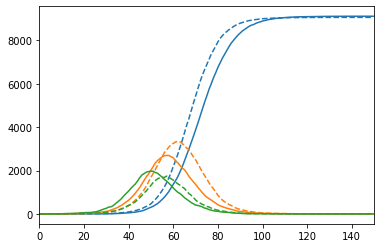

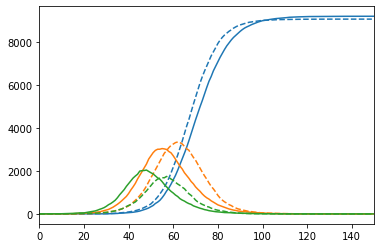

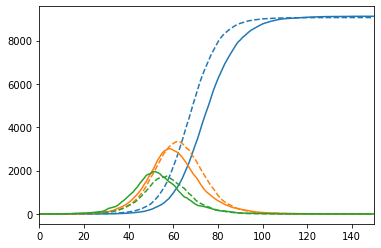

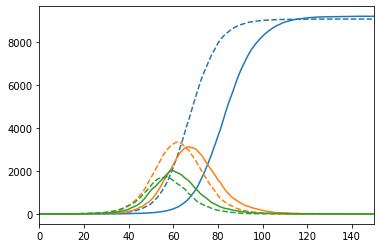

In [69]:
for step in range(h_loaded.max_t-3, h_loaded.max_t+1):
    df, w = h_loaded.get_distribution(m=0, t=step)
    par_means = {col: weighted_quantile(df[col].values, [0.5], sample_weight=w ).item() for col in df.columns}
    sim_data, _ = model(par_means)
    plt.figure()
    for field in fields:
        lines = plt.plot(sim_data[field])
        col = lines[0].get_color()
        plt.plot(data[field], color=col, ls="--")
    # plt.plot(sim_data["is_quarantined"], color="k", ls="-")
    plt.xlim(0, 150)
    

INFO:contagion:Welcome to contagion!
INFO:contagion:This package will help you model the spread of infections
INFO:contagion:Starting population construction
DEBUG:contagion.population:The interaction intensity pdf
INFO:contagion.population:Constructing social circles for the population
DEBUG:contagion:Storing for later use
INFO:contagion:Finished the population
INFO:contagion:Starting the infection construction
DEBUG:contagion.infection:The infection probability pdf
DEBUG:contagion.infection:The infection duration pdf
DEBUG:contagion.infection:The incubation duration pdf
DEBUG:contagion.infection:The latency duration pdf
DEBUG:contagion.infection:The recovery time pdf
DEBUG:contagion.infection:Symptoms pdf
DEBUG:contagion.infection:The hospitalization pdfs
DEBUG:contagion.infection:The mortality pdfs
INFO:contagion:Finished the infection construction
INFO:contagion:Starting the measure construction
INFO:contagion.measures:Using contact tracing
DEBUG:contagion.measures:Number of people

(0.0, 150.0)

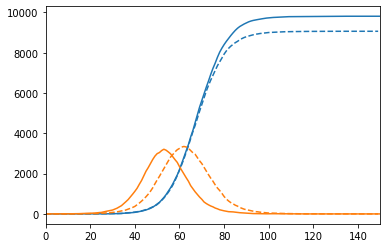

In [19]:

for field in fields:
    lines = plt.plot(sim_data[field])
    col = lines[0].get_color()
    plt.plot(data[field], color=col, ls="--")
plt.xlim(0, 150)